In [189]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adrianapsay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [292]:
import gzip
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string


data = []
file_path = "renttherunway_final_data.json.gz"

with gzip.open(file_path, 'rt', encoding='utf-8') as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Error decoding line: {e}")

df = pd.DataFrame(data)
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"


In [293]:
df['review_summary'].isna().sum()

0

In [294]:
df['review_text'].isna().sum()

0

In [295]:
df = df.dropna(subset=['rating'])

In [296]:
df['rating'].isna().sum()

0

## Data Cleaning

In [191]:
overview = df.info()
overview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   fit             192544 non-null  object
 1   user_id         192544 non-null  object
 2   bust size       174133 non-null  object
 3   item_id         192544 non-null  object
 4   weight          162562 non-null  object
 5   rating          192462 non-null  object
 6   rented for      192534 non-null  object
 7   review_text     192544 non-null  object
 8   body type       177907 non-null  object
 9   review_summary  192544 non-null  object
 10  category        192544 non-null  object
 11  height          191867 non-null  object
 12  size            192544 non-null  int64 
 13  age             191584 non-null  object
 14  review_date     192544 non-null  object
dtypes: int64(1), object(14)
memory usage: 22.0+ MB


In [192]:
### Descriptive Statistics
descriptive_stats = df.describe(include="all")
descriptive_stats

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
count,192544,192544,174133,192544,162562,192462,192534,192544,177907,192544,192544,191867,192544.000000,191584,192544
unique,3,105571,106,5850,190,5,9,191031,7,154740,68,24,NaN,89,2274
top,fit,691468,34b,126335,130lbs,10,wedding,.,hourglass,Stylist Review,dress,"5' 4""",NaN,31,"June 15, 2016"
freq,142058,436,27285,2241,14370,124537,57784,63,55349,977,92884,28012,NaN,14522,844
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.245175,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.494877,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,NaN,NaN


### Convert Height to Float and Remove 'lbs' from 'weight' Column

In [193]:
df['height'].isna().sum()

677

In [194]:
# small null values for height; we can just drop
df = df.dropna(subset=['height'])

In [195]:
df['height'].isna().sum()

0

In [196]:
def height_to_float(height):
    feet, inches = height.split("' ")
    inches = inches.replace("\"", "")
    return float(feet) + float(inches) / 12

In [197]:
df['weight']

0         137lbs
1         132lbs
2            NaN
3         135lbs
4         145lbs
           ...  
192539    140lbs
192540    100lbs
192541    135lbs
192542    165lbs
192543    155lbs
Name: weight, Length: 191867, dtype: object

In [198]:
# too many null values for weight, cant drop them
df['weight'].isna().sum()

29749

In [199]:
def clean_weight(value):
    if pd.isna(value):
        return np.nan
    return float(value.replace('lbs', ''))
df['weight'] = df['weight'].apply(clean_weight)

In [200]:
df['weight']

0         137.0
1         132.0
2           NaN
3         135.0
4         145.0
          ...  
192539    140.0
192540    100.0
192541    135.0
192542    165.0
192543    155.0
Name: weight, Length: 191867, dtype: float64

In [201]:
df['height (in)'] = df['height'].apply(height_to_float)

In [202]:
df['height (in)']

0         5.666667
1         5.500000
2         5.333333
3         5.416667
4         5.750000
            ...   
192539    5.750000
192540    5.083333
192541    5.666667
192542    5.500000
192543    5.500000
Name: height (in), Length: 191867, dtype: float64

### Replace missing 'weight' values with the mean of the weight for a given height

In [203]:
mean_weights_by_height = df.groupby('height (in)')['weight'].mean()

In [204]:
df['weight'] = df.apply(
    lambda row: mean_weights_by_height[row['height (in)']] if pd.isna(row['weight']) else row['weight'],
    axis=1
)

In [205]:
df['weight'].isna().sum()

0

### Dropping Nulls for Columns that Don't Have a lot of Nulls

In [206]:
# not a lot of null values for age, we can drop
df['age'].isna().sum()

952

In [207]:
df = df.dropna(subset=['age'])

In [208]:
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,height (in)
0,fit,420272,34d,2260466,137.000000,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016",5.666667
1,fit,273551,34b,153475,132.000000,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013",5.500000
2,fit,360448,NaN,1063761,133.294508,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015",5.333333
3,fit,909926,34c,126335,135.000000,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014",5.416667
4,fit,151944,34b,616682,145.000000,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016",5.750000


In [209]:
df = df.dropna(subset=['rating'])

In [215]:
df['rating'].isna().sum()

0

In [216]:
df.shape

(190834, 18)

### Text Preprocessing (removing stopwords, punctuation, converting to Word2Vec Dense Embeddings)

In [297]:
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def clean_text(text):
    text = text.lower()
    text = ''.join([c for c in text if c not in punctuation])
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return tokens
df['cleaned_text'] = df['review_text'].apply(clean_text)

In [298]:
df['cleaned_text'].iloc[1]

['rented',
 'dress',
 'photo',
 'shoot',
 'theme',
 'hollywood',
 'glam',
 'big',
 'beautiful',
 'hats',
 'dress',
 'comfortable',
 'easy',
 'move',
 'around',
 'definitely',
 'list',
 'rent',
 'another',
 'formal',
 'event']

In [299]:
df['review_text'].iloc[1]

'I rented this dress for a photo shoot. The theme was "Hollywood Glam and Big Beautiful Hats". The dress was very comfortable and easy to move around in. It is definitely on my list to rent again for another formal event. '

In [300]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=df['cleaned_text'], vector_size=100, window=5, min_count=5, sg=1)

def get_review_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

df['review_embedding'] = df['cleaned_text'].apply(lambda x: get_review_vector(x, model))

### Encode Classes (Rating)

In [301]:
df['rating'].unique()

array(['10', '8', '4', '6', '2'], dtype=object)

In [302]:
rating_classes = df['rating'].unique()
encoding_dict = {}

for i in range(len(rating_classes)):
    cur_class = rating_classes[i]
    encoding_dict[cur_class] = i

In [303]:
encoding_dict

{'10': 0, '8': 1, '4': 2, '6': 3, '2': 4}

In [304]:
df['rating_label'] = df['rating'].map(encoding_dict)

### Split Train/Test Data (80/20)

In [305]:
X = np.vstack(df['review_embedding'].values)
y = df['rating_label']

In [306]:
len(X)

192462

In [307]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Model 1 to Predict Ratings: Decision Tree

In [308]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [309]:
inverse_encoding_dict = {v: k for k, v in encoding_dict.items()}
target_names = [inverse_encoding_dict[i] for i in range(len(inverse_encoding_dict))]
print(target_names)


['10', '8', '4', '6', '2']


In [311]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = dt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))

Accuracy: 0.6546644844517185
              precision    recall  f1-score   support

          10       0.70      0.89      0.79     24818
           8       0.44      0.29      0.35     10763
           4       0.00      0.00      0.00       549
           6       0.00      0.00      0.00      2146
           2       0.00      0.00      0.00       217

    accuracy                           0.65     38493
   macro avg       0.23      0.24      0.23     38493
weighted avg       0.58      0.65      0.60     38493



/Users/adrianapsay/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adrianapsay/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adrianapsay/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

### Decision Tree Hyperparameter Tuning

In [312]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}


dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Accuracy: 0.6550214602818725


In [386]:
best_params = grid_search.best_params_

best_dt = DecisionTreeClassifier(**best_params, random_state=42)
best_dt.fit(X_train, y_train)

y_pred = best_dt.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))


Accuracy: 0.6677058166419868
              precision    recall  f1-score   support

          10       0.71      0.92      0.80     24818
           8       0.44      0.26      0.33     10763
           4       0.00      0.00      0.00       549
           6       0.00      0.00      0.00      2146
           2       0.00      0.00      0.00       217

    accuracy                           0.67     38493
   macro avg       0.23      0.24      0.23     38493
weighted avg       0.58      0.67      0.61     38493



In [318]:
len(X[0])

100

### Model 2: Random Forest

In [319]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    min_samples_split=2,
    random_state=42,
    criterion='gini'
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))


Accuracy: 0.6730314602655029
              precision    recall  f1-score   support

          10       0.70      0.95      0.81     24818
           8       0.48      0.21      0.30     10763
           4       0.00      0.00      0.00       549
           6       0.47      0.02      0.04      2146
           2       0.00      0.00      0.00       217

    accuracy                           0.67     38493
   macro avg       0.33      0.24      0.23     38493
weighted avg       0.61      0.67      0.60     38493



### Using 'review_summary' as an additional feature (convert to embedding and add to embedding data)

In [320]:
# Clean and tokenize the `review_summary` column
def preprocess_text(text):
    punctuation = set(string.punctuation)
    text = ''.join([c for c in text.lower() if c not in punctuation])
    return text.split()

df['cleaned_summary'] = df['review_summary'].apply(preprocess_text)

In [321]:
# Train Word2Vec on `cleaned_summary`
summary_model = Word2Vec(sentences=df['cleaned_summary'], vector_size=100, window=5, min_count=5, sg=1)

In [322]:
# Create embeddings for `review_summary`
def get_summary_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

df['summary_embedding'] = df['cleaned_summary'].apply(lambda x: get_summary_vector(x, summary_model))


In [323]:
# stack embeddings into a single feature matrix
review_embeddings = np.vstack(df['review_embedding'].values)  # embeddings for review_text
summary_embeddings = np.vstack(df['summary_embedding'].values)  # embeddings for review_summary

# combine both review and summary embeddings
X2 = np.hstack((review_embeddings, summary_embeddings))


### Train/Test Split (80/20) using new embeddings data (both review and summary embeddings as one embedding)

In [324]:
from sklearn.model_selection import train_test_split

y = df['rating_label']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)


### Model 1: Decision Tree (with new data)

In [330]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=6, random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
from sklearn.metrics import classification_report, accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6694463928506482
              precision    recall  f1-score   support

           0       0.73      0.89      0.80     24818
           1       0.46      0.33      0.38     10763
           2       0.00      0.00      0.00       549
           3       0.34      0.07      0.12      2146
           4       0.00      0.00      0.00       217

    accuracy                           0.67     38493
   macro avg       0.30      0.26      0.26     38493
weighted avg       0.62      0.67      0.63     38493



/Users/adrianapsay/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adrianapsay/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adrianapsay/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

### Decision Tree Hyperparameter Tuning (on new data)

In [377]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}


dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Accuracy: 0.6687450025423004


In [381]:
X_train[0]

array([-0.15163262,  0.12635134, -0.02539893,  0.07064352,  0.00498054,
       -0.21544647,  0.10630358,  0.32687667, -0.23263918, -0.02303472,
       -0.09573582, -0.17785227,  0.11612959,  0.07942446, -0.02963191,
       -0.03982796,  0.10022176, -0.16955055,  0.00194514, -0.32759598,
       -0.02558069,  0.02494655,  0.04779644, -0.12729198, -0.12916368,
       -0.16216335, -0.11464684, -0.12235966, -0.21679392,  0.06753298,
        0.17051405,  0.11757316,  0.14099091, -0.06484207, -0.13332435,
        0.20840102,  0.10269696, -0.13613704, -0.1748672 , -0.31695315,
        0.04665475, -0.16265413, -0.06530238,  0.04220283,  0.14941189,
       -0.14682774, -0.05255331, -0.03412634,  0.06019233, -0.00974417,
        0.03733651, -0.08591647, -0.08607954, -0.03489967, -0.01905094,
        0.1111279 ,  0.01476448,  0.05706666, -0.10714532,  0.04506027,
        0.04383473,  0.08257332,  0.17414959,  0.02913462, -0.18906258,
        0.19249557,  0.158986  ,  0.24322155, -0.23665223,  0.19

In [388]:
best_params = grid_search.best_params_

# train new model with the best parameters
best_dt = DecisionTreeClassifier(**best_params, random_state=42)
best_dt.fit(X_train, y_train)

# evaluating
y_pred = best_dt.predict(X_test)

print("Best Parameters for Decision Tree:", grid_search.best_params_)
print("Accuracy for Tuned Decision Tree:", accuracy_score(y_test, y_pred))
print("Evaluation Metrics for Tuned Decision Tree:")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))


Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy for Tuned Decision Tree: 0.6677058166419868
Evaluation Metrics for Tuned Decision Tree:
              precision    recall  f1-score   support

          10       0.71      0.92      0.80     24818
           8       0.44      0.26      0.33     10763
           4       0.00      0.00      0.00       549
           6       0.00      0.00      0.00      2146
           2       0.00      0.00      0.00       217

    accuracy                           0.67     38493
   macro avg       0.23      0.24      0.23     38493
weighted avg       0.58      0.67      0.61     38493



In [408]:
best_dt

DecisionTreeClassifier(max_depth=5, random_state=42)

In [409]:
y_train_pred = best_dt.predict(X_train)

print(f"Fine-Tuned Decision Tree Accuracy on Training Set: {accuracy_score(y_train, y_train_pred)}")
print("Fine-Tuned Decision Tree Evaluation Metrics on Training Set:")
print(classification_report(y_train, y_train_pred, target_names=target_names, zero_division=0))


Fine-Tuned Decision Tree Accuracy on Training Set: 0.6712520052737889
Fine-Tuned Decision Tree Evaluation Metrics on Training Set:
              precision    recall  f1-score   support

          10       0.72      0.92      0.81     99719
           8       0.44      0.26      0.33     42628
           4       0.00      0.00      0.00      2242
           6       0.00      0.00      0.00      8551
           2       0.00      0.00      0.00       829

    accuracy                           0.67    153969
   macro avg       0.23      0.24      0.23    153969
weighted avg       0.59      0.67      0.61    153969



### Visualizing Accuracy for Different Parameter Combinations (Decision Tree)

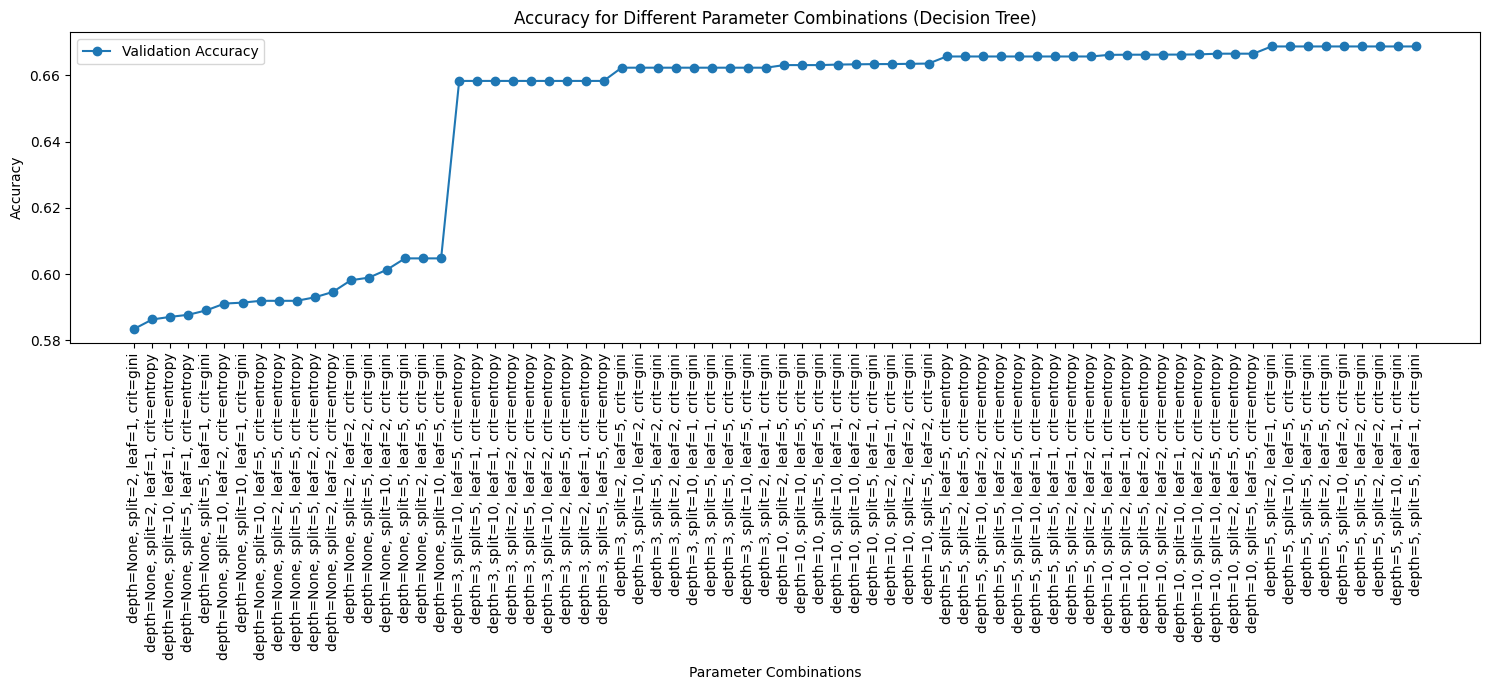

In [396]:
import matplotlib.pyplot as plt
import numpy as np

results = grid_search.cv_results_

param_combinations = results['params']
mean_train_scores = results['mean_train_score'] if 'mean_train_score' in results else results['mean_test_score']  # Some versions don't calculate mean_train_score
mean_test_scores = results['mean_test_score']
std_test_scores = results['std_test_score']

x_labels = [
    f"depth={params['max_depth']}, split={params['min_samples_split']}, leaf={params['min_samples_leaf']}, crit={params['criterion']}"
    for params in param_combinations
]

sorted_indices = np.argsort(mean_test_scores)
x_labels = np.array(x_labels)[sorted_indices]
mean_train_scores = np.array(mean_train_scores)[sorted_indices]
mean_test_scores = np.array(mean_test_scores)[sorted_indices]

plt.figure(figsize=(15, 7))
x = np.arange(len(x_labels))

plt.plot(x, mean_test_scores, label="Validation Accuracy", marker='o')

plt.xticks(x, x_labels, rotation=90)
plt.xlabel("Parameter Combinations")
plt.ylabel("Accuracy")
plt.title("Accuracy for Different Parameter Combinations (Decision Tree)")
plt.legend()
plt.tight_layout()

plt.show()


### Model 2: Random Forest (on new data)

In [271]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=2,
    random_state=42,
    criterion='gini'
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))


Accuracy: 0.6841250294757251
              precision    recall  f1-score   support

          10       0.71      0.98      0.82     24746
           8       0.49      0.17      0.25     10512
           4       0.00      0.00      0.00       590
           6       0.41      0.05      0.10      2131
           2       0.00      0.00      0.00       188

    accuracy                           0.68     38167
   macro avg       0.32      0.24      0.23     38167
weighted avg       0.62      0.68      0.61     38167



/Users/adrianapsay/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adrianapsay/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adrianapsay/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

### Random Forest Hyperparameter Tuning (again, on new data)

In [272]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42, criterion='gini')

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Best Parameters: {'max_depth': 12, 'min_samples_split': 2, 'n_estimators': 150}
Best Accuracy: 0.68645483306805


### Random Foret Hyperparameter Tuning, Refined on a Specific Range for each Hyperparameter
Decided to use these ranges as they seem to garner better performance during tuning.

In [392]:
param_grid_refined = {
    'n_estimators': [200, 250, 300],
    'max_depth': [20, 25],
    'min_samples_split': [2],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)

grid_search_refined = GridSearchCV(estimator=rf, param_grid=param_grid_refined, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_refined.fit(X_train, y_train)

print("Refined Best Parameters:", grid_search_refined.best_params_)
print("Refined Best Accuracy:", grid_search_refined.best_score_)


/Users/adrianapsay/miniforge3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Refined Best Parameters: {'criterion': 'entropy', 'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 300}
Refined Best Accuracy: 0.6941332346121621


### Evaluating Performance on Tuned Parameters for Random Forest

In [394]:
best_rf_params = grid_search_refined.best_params_

best_rf = RandomForestClassifier(**best_rf_params, random_state=42)
best_rf.fit(X_train, y_train)

y_pred_rf = best_rf.predict(X_test)

print("Best Parameters for Random Forest:", best_rf_params)
print("Accuracy for Tuned Random Forest:", accuracy_score(y_test, y_pred_rf))
print("Evaluation Metrics for Tuned Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=target_names, zero_division=0))

Best Parameters for Random Forest: {'criterion': 'entropy', 'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy for Tuned Random Forest: 0.6939443535188216
Evaluation Metrics for Tuned Random Forest:
              precision    recall  f1-score   support

          10       0.72      0.96      0.83     24818
           8       0.53      0.24      0.33     10763
           4       0.43      0.02      0.03       549
           6       0.46      0.15      0.23      2146
           2       0.67      0.01      0.02       217

    accuracy                           0.69     38493
   macro avg       0.56      0.28      0.29     38493
weighted avg       0.65      0.69      0.64     38493



In [406]:
y_train_pred = best_rf.predict(X_train)
print(f"Fine-Tuned Random Forest Accuracy on Training Set: {accuracy_score(y_train, y_train_pred)}")
print("Fine-Tuned Random Forest Evaluation Metrics on Training Set:")
print(classification_report(y_train, y_train_pred, target_names=target_names, zero_division=0))

Fine-Tuned Random Forest Accuracy on Training Set: 0.999694743747118
Fine-Tuned Random Forest Evaluation Metrics on Training Set:
              precision    recall  f1-score   support

          10       1.00      1.00      1.00     99719
           8       1.00      1.00      1.00     42628
           4       1.00      1.00      1.00      2242
           6       1.00      1.00      1.00      8551
           2       1.00      1.00      1.00       829

    accuracy                           1.00    153969
   macro avg       1.00      1.00      1.00    153969
weighted avg       1.00      1.00      1.00    153969



### Visualize Accuracy for Different Parameter Combinations (Random Forest)

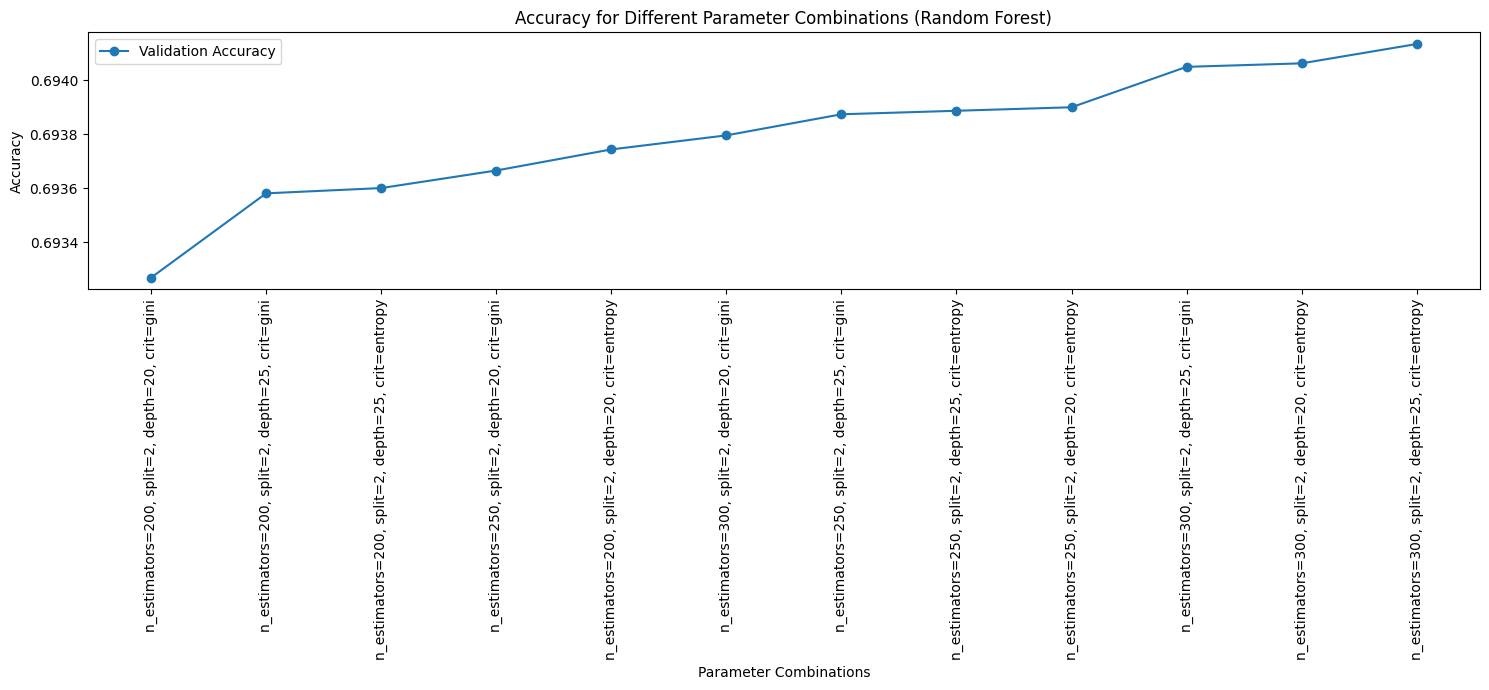

In [395]:
import matplotlib.pyplot as plt
import numpy as np

results = grid_search_refined.cv_results_

param_combinations = results['params']
mean_train_scores = results['mean_train_score'] if 'mean_train_score' in results else results['mean_test_score']
mean_test_scores = results['mean_test_score']
std_test_scores = results['std_test_score']

x_labels = [
    f"n_estimators={params['n_estimators']}, split={params['min_samples_split']}, depth={params['max_depth']}, crit={params['criterion']}"
    for params in param_combinations
]

sorted_indices = np.argsort(mean_test_scores)
x_labels = np.array(x_labels)[sorted_indices]
mean_train_scores = np.array(mean_train_scores)[sorted_indices]
mean_test_scores = np.array(mean_test_scores)[sorted_indices]

plt.figure(figsize=(15, 7))
x = np.arange(len(x_labels))

plt.plot(x, mean_test_scores, label="Validation Accuracy", marker='o')

plt.xticks(x, x_labels, rotation=90)
plt.xlabel("Parameter Combinations")
plt.ylabel("Accuracy")
plt.title("Accuracy for Different Parameter Combinations (Random Forest)")
plt.legend()
plt.tight_layout()

plt.show()


### Testing a Certain Random Forest Model with Specific Hyperparameters
Decided to use the hyperparameters below for Random Forest as a 'test'. Configured to these hyperparameters after seeing the accuracy for different hyperparameter combinations.

In [337]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf = RandomForestClassifier(
    n_estimators=275,
    max_depth=25,
    min_samples_split=2,
    random_state=42,
    criterion='gini'
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))


Accuracy: 0.6919180110669473
              precision    recall  f1-score   support

          10       0.73      0.95      0.82     24818
           8       0.51      0.26      0.34     10763
           4       0.36      0.01      0.02       549
           6       0.41      0.12      0.18      2146
           2       0.50      0.00      0.01       217

    accuracy                           0.69     38493
   macro avg       0.50      0.27      0.28     38493
weighted avg       0.64      0.69      0.64     38493



In [333]:
len(X_train[0])

200

## Task 2: Recommender Systems Using Item2Vec

In [343]:
df.head(5)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,cleaned_text,review_embedding,rating_label,cleaned_summary,summary_embedding
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016","[adorable, romper, belt, zipper, little, hard,...","[-0.06486818, 0.17025289, 0.026628315, 0.03265...",0,"[so, many, compliments]","[0.083136745, 0.28485033, -0.29237902, 0.00324..."
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013","[rented, dress, photo, shoot, theme, hollywood...","[-0.019751873, 0.14822233, 0.07309279, 0.16895...",0,"[i, felt, so, glamourous]","[-0.051250108, 0.26099145, -0.15311159, 0.0204..."
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015","[hugged, right, places, perfect, dress, event,...","[-0.16576023, 0.32447112, 0.09333682, 0.153376...",0,"[it, was, a, great, time, to, celebrate, the, ...","[-0.08969114, 0.042956658, -0.19331612, 0.1204..."
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014","[rented, companys, black, tie, awards, banquet...","[-0.019564979, 0.087300315, 0.0338187, 0.00787...",1,"[dress, arrived, on, time, and, in, perfect, c...","[-0.014081143, 0.108364865, 0.08184557, 0.1394..."
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016","[always, petite, upper, body, extremely, athle...","[-0.11066208, 0.17325942, 0.025174031, 0.00490...",0,"[was, in, love, with, this, dress]","[-0.15077111, 0.10392502, 0.17788513, 0.109635..."


In [344]:
df['category'].unique()

array(['romper', 'gown', 'sheath', 'dress', 'leggings', 'top', 'jumpsuit',
       'sweater', 'jacket', 'shirtdress', 'maxi', 'shift', 'pants',
       'shirt', 'mini', 'skirt', 'pullover', 'blouse', 'suit', 'coat',
       'trench', 'bomber', 'cape', 'blazer', 'vest', 'duster', 'ballgown',
       'tank', 'poncho', 'frock', 'tunic', 'cardigan', 'culottes', 'down',
       'trouser', 'midi', 'pant', 'legging', 'print', 'knit', 'culotte',
       'sweatshirt', 'peacoat', 'kaftan', 'overalls', 'jogger', 'tee',
       'combo', 'henley', 'cami', 'blouson', 'turtleneck', 'trousers',
       'overcoat', 'hoodie', 't-shirt', 'caftan', 'tight', 'kimono',
       'for', 'crewneck', 'skirts', 'parka', 'buttondown', 'skort',
       'sweatershirt', 'sweatpants', 'jeans'], dtype=object)

In [340]:
df['item_id'].iloc[0]

'2260466'

In [338]:
from collections import defaultdict

user_item_sequences = defaultdict(list)
for _, row in df.iterrows():
    user_item_sequences[row['user_id']].append(row['item_id'])

item_sequences = list(user_item_sequences.values())

In [342]:
from gensim.models import Word2Vec

item2vec_model = Word2Vec(
    sentences=item_sequences,
    vector_size=10,
    window=5,
    min_count=1,
    sg=1,
    workers=4
)

item_embedding = item2vec_model.wv['2260466']

similar_items = item2vec_model.wv.most_similar('2260466', topn=5)
print(similar_items)


[('2517880', 0.9976062178611755), ('2014299', 0.9967440962791443), ('2578061', 0.9961701035499573), ('2764635', 0.99601149559021), ('2464025', 0.9959350228309631)]


In [345]:
# a dictionary mapping item_id to item_name
item_id_to_name = dict(zip(df['item_id'], df['category']))


In [347]:
len(item_id_to_name)

5850

In [349]:
item_id_to_name['2517880']

'blazer'

### Given a particular item specified by 'item_id', recommend similar items!

In [ ]:
item = df['item_id'].iloc[0]

similar_items = item2vec_model.wv.most_similar(item, topn=5)

print(f"Current Item: {item_id_to_name[item]}\n")
print("Recommended Items:")
for similar_item, similarity in similar_items:
    item_name = item_id_to_name[similar_item]
    print(f"Item ID: {similar_item}, Name: {item_name}, Similarity: {similarity}")


Current Item: romper

Recommended Items:
Item ID: 2517880, Name: blazer, Similarity: 0.9976062178611755
Item ID: 2014299, Name: top, Similarity: 0.9967440962791443
Item ID: 2578061, Name: jacket, Similarity: 0.9961701035499573
Item ID: 2764635, Name: jumpsuit, Similarity: 0.99601149559021
Item ID: 2464025, Name: sweater, Similarity: 0.9959350228309631


### Using Precision@K and and Recall@K to measure the quality of a recommendation

In [373]:
def precision_at_k(recommended_items, relevant_items, k, item_id_to_name):

    recommended_names = [item_id_to_name[i] for i in recommended_items[:k]]
    relevant_names = {item_id_to_name[i] for i in relevant_items if i in item_id_to_name}
    relevant_k = set(recommended_names) & relevant_names
    return len(relevant_k) / k

def recall_at_k(recommended_items, relevant_items, k, item_id_to_name):

    recommended_names = [item_id_to_name[i] for i in recommended_items[:k]]
    relevant_names = {item_id_to_name[i] for i in relevant_items if i in item_id_to_name}
    relevant_k = set(recommended_names) & relevant_names
    return len(relevant_k) / len(relevant_names) if relevant_names else 0


### Example Use of the Recommender System (documented with comments)

In [375]:
# Example for the first item in the dataset
item = str(df['item_id'].iloc[0])

# get recommendations using Item2Vec
similar_items = item2vec_model.wv.most_similar(item, topn=5)

# create a list of recommended item IDs
recommended_items = [similar_item for similar_item, _ in similar_items]

# retrieve relevant items for the user who interacted with the current item
user_id = df.loc[df['item_id'] == item, 'user_id'].values[0]
relevant_items = set(df.loc[df['user_id'] == user_id, 'item_id'])

# print the current item and its recommendations
print(f"Current Item: {item_id_to_name[item]}\n")
print("Recommended Items:")
for similar_item, similarity in similar_items:
    print(f"{item_id_to_name[similar_item]} (ID: {similar_item}, Similarity: {similarity:.4f})")

print("\nRelevant Items:")
for relevant_item in relevant_items:
    print(item_id_to_name[relevant_item])

# calculate Precision@K and Recall@K (our evaluation metrics for the recommender system)
k = 5
precision = precision_at_k(recommended_items, relevant_items, k, item_id_to_name)
recall = recall_at_k(recommended_items, relevant_items, k, item_id_to_name)

print(f"\nPrecision@{k}: {precision:.4f}")
print(f"Recall@{k}: {recall:.4f}")


Current Item: romper

Recommended Items:
blazer (ID: 2517880, Similarity: 0.9976)
top (ID: 2014299, Similarity: 0.9967)
jacket (ID: 2578061, Similarity: 0.9962)
jumpsuit (ID: 2764635, Similarity: 0.9960)
sweater (ID: 2464025, Similarity: 0.9959)

Relevant Items:
romper
jumpsuit
jumpsuit
jumpsuit
dress
dress

Precision@5: 0.2000
Recall@5: 0.3333


In [368]:
for i in recommended_items:
    print(item_id_to_name[i])

blazer
top
jacket
jumpsuit
sweater


In [369]:
for i in relevant_items:
    print(item_id_to_name[i])

romper
jumpsuit
jumpsuit
jumpsuit
dress
dress


### Function that calculates the average precision and recall @ K, across the entire dataset.

In [376]:
# Function to calculate average Precision@K and Recall@K
def average_precision_recall_at_k(df, item2vec_model, k, item_id_to_name):

    precision_list = []
    recall_list = []
    
    for user_id in df['user_id'].unique():
        user_items = df[df['user_id'] == user_id]['item_id'].unique()
        
        for item in user_items:
            item = str(item)
            
            if item not in item2vec_model.wv:
                continue
            
            similar_items = item2vec_model.wv.most_similar(item, topn=k)
            recommended_items = [similar_item for similar_item, _ in similar_items]
            
            relevant_items = set(user_items)
            
            precision = precision_at_k(recommended_items, relevant_items, k, item_id_to_name)
            recall = recall_at_k(recommended_items, relevant_items, k, item_id_to_name)
            
            precision_list.append(precision)
            recall_list.append(recall)
    
    avg_precision = sum(precision_list) / len(precision_list) if precision_list else 0
    avg_recall = sum(recall_list) / len(recall_list) if recall_list else 0
    
    return avg_precision, avg_recall

# usage
k = 5
avg_precision, avg_recall = average_precision_recall_at_k(df, item2vec_model, k, item_id_to_name)

# results of above usage (print)
print(f"Average Precision@{k}: {avg_precision:.4f}")
print(f"Average Recall@{k}: {avg_recall:.4f}")


Average Precision@5: 0.2311
Average Recall@5: 0.6335
